In [1]:
from torch_geometric.loader import DataLoader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

/data/conghao001/anaconda3/envs/gnndrug/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'1.11.0'

In [3]:
device = torch.device("cuda:0")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [4]:
from utils_data import TestbedDataset
from models import GATNet_E, GATNet, GCNNet

In [5]:
model = GATNet()
model_path = 'root_folder/root_013/models/model_GAT-EP300-SW801010_GDSC.model'

# model = GCNNet()
# model_path = 'root_folder/root_003/models/model_GCN-EP300-SW801010_GDSC.model'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

GATNet(
  (gcn1): GATConv(334, 334, heads=10)
  (gcn2): GATConv(3340, 128, heads=1)
  (fc_g1): Linear(in_features=128, out_features=128, bias=True)
  (conv_xt_1): Conv1d(1, 32, kernel_size=(8,), stride=(1,))
  (pool_xt_1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_2): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
  (pool_xt_2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv_xt_3): Conv1d(64, 128, kernel_size=(8,), stride=(1,))
  (pool_xt_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1_xt): Linear(in_features=2944, out_features=128, bias=True)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
branch_folder = "root_folder/root_013"
dataset = 'GDSC'
test_data = TestbedDataset(root=branch_folder, dataset=dataset+'_test_mix')

Pre-processed data found: root_folder/root_013/processed/GDSC_test_mix.pt, loading ...


In [7]:
test_batch = 1
test_loader = DataLoader(test_data, batch_size=test_batch, shuffle=False)

In [8]:
i = 0
for data in test_loader:
    i += 1
    print(data)
    if i >= 5:
        break

DataBatch(x=[32, 334], edge_index=[2, 74], y=[1], edge_features=[74, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[32], ptr=[2])
DataBatch(x=[27, 334], edge_index=[2, 60], y=[1], edge_features=[60, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[27], ptr=[2])
DataBatch(x=[29, 334], edge_index=[2, 64], y=[1], edge_features=[64, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[29], ptr=[2])
DataBatch(x=[37, 334], edge_index=[2, 80], y=[1], edge_features=[80, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[37], ptr=[2])
DataBatch(x=[31, 334], edge_index=[2, 68], y=[1], edge_features=[68, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[31], ptr=[2])


In [9]:
from torch_geometric.nn import GNNExplainer

In [10]:
# test one drug
one = next(iter(test_loader))
data = one.to(device)
print(data)

explainer = GNNExplainer(model, lr=1e-4, epochs=300, return_type='regression')

x = data.x
edge_index = data.edge_index
y = data.y
batch_drug = data.batch
edge_features = data.edge_features
x_cell_mut = data.target

# model_args = (
#     x_cell_mut,
#     batch_drug,
#     edge_features
# )

kwargs = {
    "x_cell_mut": x_cell_mut,
    "batch_drug": batch_drug,
    "edge_feat": edge_features
}

node_feature_mask, edge_mask = explainer.explain_graph(x = x, edge_index = edge_index, x_cell_mut = x_cell_mut, edge_feat = edge_features)
# node_feature_mask, edge_mask = explainer.explain_graph(x, edge_index, **kwargs)


DataBatch(x=[32, 334], edge_index=[2, 74], y=[1], edge_features=[74, 4], smiles=[1], drug_name=[1], cell_line_name=[1], target=[1, 735], c_size=[1], batch=[32], ptr=[2])


Explain graph: 100%|██████████████████████████████████████████████| 300/300 [00:13<00:00, 22.42it/s]


- node_feature_mask: size = node feature length (334/...), importance of each node feature (invariant of atoms)
- edge_mask: size = edge number, importance of edges, stored in the sequence of nodes (0,1),(0,5),(1,...

In [11]:
node_feature_mask

tensor([0.5058, 0.4664, 0.5176, 0.4677, 0.4646, 0.4935, 0.5168, 0.4917, 0.5293,
        0.5053, 0.4949, 0.4693, 0.4824, 0.5203, 0.4581, 0.5371, 0.5064, 0.4963,
        0.5075, 0.4280, 0.4659, 0.4695, 0.5135, 0.4807, 0.4800, 0.4976, 0.5225,
        0.4719, 0.4355, 0.4825, 0.4740, 0.4513, 0.4967, 0.4812, 0.5243, 0.5013,
        0.4894, 0.4608, 0.4523, 0.4653, 0.5151, 0.5128, 0.5069, 0.5117, 0.5068,
        0.4737, 0.4943, 0.5064, 0.4931, 0.4808, 0.4890, 0.4966, 0.4981, 0.5064,
        0.4589, 0.5271, 0.5027, 0.4842, 0.4689, 0.4740, 0.5444, 0.4930, 0.4937,
        0.5052, 0.4623, 0.4581, 0.4601, 0.4924, 0.5262, 0.4463, 0.5105, 0.5203,
        0.4718, 0.4934, 0.4950, 0.4806, 0.5091, 0.4788, 0.4406, 0.4482, 0.4787,
        0.5246, 0.4677, 0.4546, 0.4684, 0.5429, 0.4843, 0.5267, 0.4882, 0.5055,
        0.4990, 0.4724, 0.4546, 0.5099, 0.4830, 0.5404, 0.5216, 0.4683, 0.4489,
        0.4904, 0.4495, 0.4842, 0.4738, 0.4521, 0.5036, 0.4819, 0.5033, 0.4724,
        0.5120, 0.4768, 0.4922, 0.4860, 

In [12]:
edge_mask_cpu = edge_mask.to('cpu')
edge_index_cpu = edge_index.to('cpu')

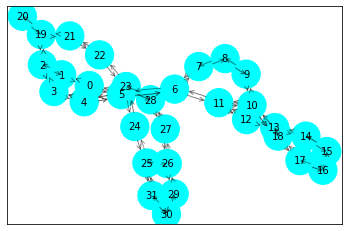

In [13]:
ax, G = explainer.visualize_subgraph(node_idx=None, edge_index=edge_index_cpu, edge_mask=edge_mask_cpu)
plt.show()

In [14]:
G[0]

AtlasView({1: {'att': 0.4866805076599121, 'edge_color': 'black'}, 5: {'att': 0.5363545417785645, 'edge_color': 'black'}})

In [15]:
explainer = GNNExplainer(model, lr=1e-4, epochs=300)

for data in test_loader:
    x = data.x
    edge_index = data.edge_index
    y = data.y
    batch = data.batch
    edge_features = data.edge_features
    target = data.target
    
    node_feature_mask, edge_mask = explainer.explain_graph(x, edge_index, batch=batch, edge_feat = edge_features)
    ax, G = explainer.visualize_subgraph(edge_index, edge_mask, y=y)

TypeError: get_initial_prediction() got multiple values for keyword argument 'batch'